# Review Tool Calls

Human-in-the-loop (HIL) interactions are crucial for [agentic systems](https://langchain-ai.github.io/langgraph/concepts/agentic_concepts/#human-in-the-loop). A common pattern is to add some human in the loop step after certain tool calls. These tool calls often lead to either a function call or saving of some information. Examples include:

- A tool call to execute SQL, which will then be run by the tool
- A tool call to generate a summary, which will then be saved to the State of the graph

Note that using tool calls is common **whether actually calling tools or not**.

There are typically a few different interactions you may want to do here:

1. Approve the tool call and continue
2. Modify the tool call manually and then continue
3. Give natural language feedback, and then pass that back to the agent instead of continuing

We can implement this in LangGraph using a [breakpoint](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/breakpoints/): breakpoints allow us to interrupt graph execution before a specific step. At this breakpoint, we can manually update the graph state taking one of the three options above

## Setup

First we need to install the packages required

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_anthropic

Next, we need to set API keys for Anthropic (the LLM we will use)

In [2]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("ANTHROPIC_API_KEY")

Optionally, we can set API key for [LangSmith tracing](https://smith.langchain.com/), which will give us best-in-class observability.

In [3]:
os.environ["LANGCHAIN_TRACING_V2"] = "true"
_set_env("LANGCHAIN_API_KEY")

## Simple Usage

Let's set up a very simple graph that facilitates this.
First, we will have an LLM call that decides what action to take.
Then we go to a human node. This node actually doesn't do anything - the idea is that we interrupt before this node and then apply any updates to the state.
After that, we check the state and either route back to the LLM or to the correct tool.

Let's see this in action!

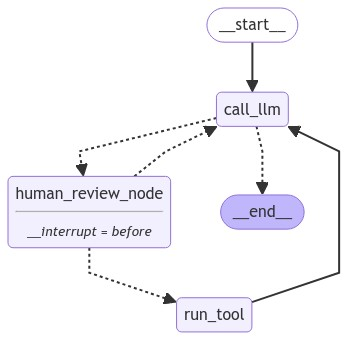

In [4]:
from typing import TypedDict, Literal
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langchain_anthropic import ChatAnthropic
from langchain_core.tools import tool
from langchain_core.messages import AIMessage
from IPython.display import Image, display


@tool
def weather_search(city: str):
    """Search for the weather"""
    print("----")
    print(f"Searching for: {city}")
    print("----")
    return "Sunny!"

model = ChatAnthropic(model_name="claude-3-5-sonnet-20240620").bind_tools([weather_search])

class State(MessagesState):
    """Simple state."""

def call_llm(state):
    return {
        "messages": [model.invoke(state['messages'])]
    }


def human_review_node(state):
    pass


def run_tool(state):
    new_messages = []
    tools = {"weather_search": weather_search}
    tool_calls = state['messages'][-1].tool_calls
    for tool_call in tool_calls:
        tool = tools[tool_call['name']]
        result = tool.invoke(tool_call['args'])
        new_messages.append({
            "role": "tool",
            "name": tool_call['name'],
            "content": result,
            "tool_call_id": tool_call['id']
        })
    return {"messages": new_messages}


def route_after_llm(state) -> Literal[END, "human_review_node"]:
    if len(state['messages'][-1].tool_calls) == 0:
        return END
    else:
        return "human_review_node"


def route_after_human(state) -> Literal["run_tool", "call_llm"]:
    if isinstance(state['messages'][-1], AIMessage):
        return "run_tool"
    else:
        return "call_llm"


builder = StateGraph(State)
builder.add_node(call_llm)
builder.add_node(run_tool)
builder.add_node(human_review_node)
builder.add_edge(START, "call_llm")
builder.add_conditional_edges("call_llm", route_after_llm)
builder.add_conditional_edges("human_review_node", route_after_human)
builder.add_edge("run_tool", "call_llm")

# Set up memory
memory = MemorySaver()

# Add
graph = builder.compile(checkpointer=memory, interrupt_before=["human_review_node"])

# View
display(Image(graph.get_graph().draw_mermaid_png()))

## Example with no review

Let's look at an example when no review is required (because no tools are called)

In [5]:
# Input
initial_input = {"messages": [{"role": "user", "content": "hi!"}]}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    print(event)

{'messages': [HumanMessage(content='hi!', id='c7cc7625-6076-421b-8518-e73caa82dc9e')]}
{'messages': [HumanMessage(content='hi!', id='c7cc7625-6076-421b-8518-e73caa82dc9e'), AIMessage(content="Hello! Welcome. How can I assist you today? Is there anything specific you'd like to know or discuss?", response_metadata={'id': 'msg_01HS2orRyy3YorjUhwMBJRm3', 'model': 'claude-3-5-sonnet-20240620', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'input_tokens': 355, 'output_tokens': 26}}, id='run-1c2f1fb1-06c1-418b-a582-ae43cbdea43b-0', usage_metadata={'input_tokens': 355, 'output_tokens': 26, 'total_tokens': 381})]}


If we check the state, we can see that it is finished

In [6]:
print("Pending Executions!")
print(graph.get_state(thread).next)

Pending Executions!
()


## Example of approving tool

Let's now look at what it looks like to approve a tool call

In [7]:
# Input
initial_input = {"messages": [{"role": "user", "content": "whats the weather in sf?"}]}

# Thread
thread = {"configurable": {"thread_id": "2"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    print(event)

{'messages': [HumanMessage(content='whats the weather in sf?', id='bcb80925-1012-43ab-9c22-b090a88f4a93')]}
{'messages': [HumanMessage(content='whats the weather in sf?', id='bcb80925-1012-43ab-9c22-b090a88f4a93'), AIMessage(content=[{'text': "Certainly! I can help you check the weather in San Francisco. To get this information, I'll use the weather search function. Let me do that for you right away.", 'type': 'text'}, {'id': 'toolu_01L3eM8wPgKf59kJrD8AgY76', 'input': {'city': 'San Francisco'}, 'name': 'weather_search', 'type': 'tool_use'}], response_metadata={'id': 'msg_0169GG1jJwbcfnsU4j5dZZZM', 'model': 'claude-3-5-sonnet-20240620', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'input_tokens': 360, 'output_tokens': 90}}, id='run-95710765-604b-4a0b-a8cf-d31d09ee9133-0', tool_calls=[{'name': 'weather_search', 'args': {'city': 'San Francisco'}, 'id': 'toolu_01L3eM8wPgKf59kJrD8AgY76', 'type': 'tool_call'}], usage_metadata={'input_tokens': 360, 'output_tokens': 90, 'total_t

If we now check, we can see that it is waiting on human review

In [8]:
print("Pending Executions!")
print(graph.get_state(thread).next)

Pending Executions!
('human_review_node',)


To approve the tool call, we can just continue the thread with no edits. To do this, we just create a new run with no inputs.

In [9]:
for event in graph.stream(None, thread, stream_mode="values"):
    print(event)

----
Searching for: San Francisco
----
{'messages': [HumanMessage(content='whats the weather in sf?', id='bcb80925-1012-43ab-9c22-b090a88f4a93'), AIMessage(content=[{'text': "Certainly! I can help you check the weather in San Francisco. To get this information, I'll use the weather search function. Let me do that for you right away.", 'type': 'text'}, {'id': 'toolu_01L3eM8wPgKf59kJrD8AgY76', 'input': {'city': 'San Francisco'}, 'name': 'weather_search', 'type': 'tool_use'}], response_metadata={'id': 'msg_0169GG1jJwbcfnsU4j5dZZZM', 'model': 'claude-3-5-sonnet-20240620', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'input_tokens': 360, 'output_tokens': 90}}, id='run-95710765-604b-4a0b-a8cf-d31d09ee9133-0', tool_calls=[{'name': 'weather_search', 'args': {'city': 'San Francisco'}, 'id': 'toolu_01L3eM8wPgKf59kJrD8AgY76', 'type': 'tool_call'}], usage_metadata={'input_tokens': 360, 'output_tokens': 90, 'total_tokens': 450}), ToolMessage(content='Sunny!', name='weather_search', i

## Edit Tool Call

Let's now say we want to edit the tool call. E.g. change some of the parameters (or even the tool called!) but then execute that tool.

In [10]:
# Input
initial_input = {"messages": [{"role": "user", "content": "whats the weather in sf?"}]}

# Thread
thread = {"configurable": {"thread_id": "5"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    print(event)

{'messages': [HumanMessage(content='whats the weather in sf?', id='f5daa87a-a08d-4e85-9f88-d7365e35e563')]}
{'messages': [HumanMessage(content='whats the weather in sf?', id='f5daa87a-a08d-4e85-9f88-d7365e35e563'), AIMessage(content=[{'text': "Certainly! I can help you find out the weather in San Francisco. To get this information, I'll use the weather search tool. Let me fetch that for you.", 'type': 'text'}, {'id': 'toolu_01KXBbM79TGZUixUpihGaiz2', 'input': {'city': 'San Francisco'}, 'name': 'weather_search', 'type': 'tool_use'}], response_metadata={'id': 'msg_0182nSFwVhkrCta3YBdeXdPN', 'model': 'claude-3-5-sonnet-20240620', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'input_tokens': 360, 'output_tokens': 89}}, id='run-e7203734-c32a-40c8-a134-0b1da81f5820-0', tool_calls=[{'name': 'weather_search', 'args': {'city': 'San Francisco'}, 'id': 'toolu_01KXBbM79TGZUixUpihGaiz2', 'type': 'tool_call'}], usage_metadata={'input_tokens': 360, 'output_tokens': 89, 'total_tokens': 4

In [11]:
print("Pending Executions!")
print(graph.get_state(thread).next)

Pending Executions!
('human_review_node',)


To do this, we first need to update the state. We can do this by passing a message in with the **same** id of the message we want to overwrite. This will have the effect of **replacing** that old message. Note that this is only possible because of the **reducer** we are using that replaces messages with the same ID - read more about that [here](/concepts/low_level/#working-with-messages-in-graph-state)

In [12]:
# To get the ID of the message we want to replace, we need to fetch the current state and find it there.
state = graph.get_state(thread)
print("Current State:")
print(state.values)
print("\nCurrent Tool Call ID:")
current_content = state.values['messages'][-1].content
current_id = state.values['messages'][-1].id
tool_call_id = state.values['messages'][-1].tool_calls[0]['id']
print(tool_call_id)

# We now need to construct a replacement tool call.
# We will change the argument to be `San Francisco, USA`
# Note that we could change any number of arguments or tool names - it just has to be a valid one
new_message = {
    "role": "assistant", 
    "content": current_content,
    "tool_calls": [
        {
            "id": tool_call_id,
            "name": "weather_search",
            "args": {"city": "San Francisco, USA"}
        }
    ],
    # This is important - this needs to be the same as the message you replacing!
    # Otherwise, it will show up as a separate message
    "id": current_id
}
graph.update_state(
    # This is the config which represents this thread
    thread, 
    # This is the updated value we want to push
    {"messages": [new_message]}, 
    # We push this update acting as our human_review_node
    as_node="human_review_node"
)

# Let's now continue executing from here
for event in graph.stream(None, thread, stream_mode="values"):
    print(event)

Current State:
{'messages': [HumanMessage(content='whats the weather in sf?', id='f5daa87a-a08d-4e85-9f88-d7365e35e563'), AIMessage(content=[{'text': "Certainly! I can help you find out the weather in San Francisco. To get this information, I'll use the weather search tool. Let me fetch that for you.", 'type': 'text'}, {'id': 'toolu_01KXBbM79TGZUixUpihGaiz2', 'input': {'city': 'San Francisco'}, 'name': 'weather_search', 'type': 'tool_use'}], response_metadata={'id': 'msg_0182nSFwVhkrCta3YBdeXdPN', 'model': 'claude-3-5-sonnet-20240620', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'input_tokens': 360, 'output_tokens': 89}}, id='run-e7203734-c32a-40c8-a134-0b1da81f5820-0', tool_calls=[{'name': 'weather_search', 'args': {'city': 'San Francisco'}, 'id': 'toolu_01KXBbM79TGZUixUpihGaiz2', 'type': 'tool_call'}], usage_metadata={'input_tokens': 360, 'output_tokens': 89, 'total_tokens': 449})]}

Current Tool Call ID:
toolu_01KXBbM79TGZUixUpihGaiz2
----
Searching for: San Francisc

## Give feedback to a tool call

Sometimes, you may not want to execute a tool call, but you also may not want to ask the user to manually modify the tool call. In that case it may be better to get natural language feedback from the user. You can then insert these feedback as a mock **RESULT** of the tool call.

This will involve adding a new message - one representing the result of the tool call - to the state.

Let's see this in action!

In [13]:
# Input
initial_input = {"messages": [{"role": "user", "content": "whats the weather in sf?"}]}

# Thread
thread = {"configurable": {"thread_id": "6"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    print(event)

{'messages': [HumanMessage(content='whats the weather in sf?', id='7be328eb-28ec-4cf3-b3ff-230a060b0ed6')]}
{'messages': [HumanMessage(content='whats the weather in sf?', id='7be328eb-28ec-4cf3-b3ff-230a060b0ed6'), AIMessage(content=[{'text': 'To get the weather information for San Francisco, I can use the weather_search function. Let me fetch that information for you.', 'type': 'text'}, {'id': 'toolu_01JNqyF542ebsXeaAinnUTKz', 'input': {'city': 'San Francisco'}, 'name': 'weather_search', 'type': 'tool_use'}], response_metadata={'id': 'msg_01T2CvhD5YaKqSAatvyZ1PfD', 'model': 'claude-3-5-sonnet-20240620', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'input_tokens': 360, 'output_tokens': 81}}, id='run-0da499dd-e88b-4f5b-a597-5dd564611df0-0', tool_calls=[{'name': 'weather_search', 'args': {'city': 'San Francisco'}, 'id': 'toolu_01JNqyF542ebsXeaAinnUTKz', 'type': 'tool_call'}], usage_metadata={'input_tokens': 360, 'output_tokens': 81, 'total_tokens': 441})]}


In [14]:
print("Pending Executions!")
print(graph.get_state(thread).next)

Pending Executions!
('human_review_node',)


To do this, we first need to update the state. We can do this by passing a message in with the same **tool call id** of the tool call we want to respond to. Note that this is a **different** ID from above.

In [15]:
# To get the ID of the message we want to replace, we need to fetch the current state and find it there.
state = graph.get_state(thread)
print("Current State:")
print(state.values)
print("\nCurrent Tool Call ID:")
tool_call_id = state.values['messages'][-1].tool_calls[0]['id']
print(tool_call_id)

# We now need to construct a replacement tool call.
# We will change the argument to be `San Francisco, USA`
# Note that we could change any number of arguments or tool names - it just has to be a valid one
new_message = {
    "role": "tool", 
    # This is our natural language feedback
    "content": "User requested changes: pass in the country as well",
    "name": "weather_search",
    "tool_call_id": tool_call_id
}
graph.update_state(
    # This is the config which represents this thread
    thread, 
    # This is the updated value we want to push
    {"messages": [new_message]}, 
    # We push this update acting as our human_review_node
    as_node="human_review_node"
)

# Let's now continue executing from here
for event in graph.stream(None, thread, stream_mode="values"):
    print(event)

Current State:
{'messages': [HumanMessage(content='whats the weather in sf?', id='7be328eb-28ec-4cf3-b3ff-230a060b0ed6'), AIMessage(content=[{'text': 'To get the weather information for San Francisco, I can use the weather_search function. Let me fetch that information for you.', 'type': 'text'}, {'id': 'toolu_01JNqyF542ebsXeaAinnUTKz', 'input': {'city': 'San Francisco'}, 'name': 'weather_search', 'type': 'tool_use'}], response_metadata={'id': 'msg_01T2CvhD5YaKqSAatvyZ1PfD', 'model': 'claude-3-5-sonnet-20240620', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'input_tokens': 360, 'output_tokens': 81}}, id='run-0da499dd-e88b-4f5b-a597-5dd564611df0-0', tool_calls=[{'name': 'weather_search', 'args': {'city': 'San Francisco'}, 'id': 'toolu_01JNqyF542ebsXeaAinnUTKz', 'type': 'tool_call'}], usage_metadata={'input_tokens': 360, 'output_tokens': 81, 'total_tokens': 441})]}

Current Tool Call ID:
toolu_01JNqyF542ebsXeaAinnUTKz
{'messages': [HumanMessage(content='whats the weather i

We can see that we now get to another breakpoint - because it went back to the model and got an entirely new prediction of what to call. Let's now approve this one and continue.

In [16]:
print("Pending Executions!")
print(graph.get_state(thread).next)

for event in graph.stream(None, thread, stream_mode="values"):
    print(event)

Pending Executions!
('human_review_node',)
----
Searching for: San Francisco, USA
----
{'messages': [HumanMessage(content='whats the weather in sf?', id='7be328eb-28ec-4cf3-b3ff-230a060b0ed6'), AIMessage(content=[{'text': 'To get the weather information for San Francisco, I can use the weather_search function. Let me fetch that information for you.', 'type': 'text'}, {'id': 'toolu_01JNqyF542ebsXeaAinnUTKz', 'input': {'city': 'San Francisco'}, 'name': 'weather_search', 'type': 'tool_use'}], response_metadata={'id': 'msg_01T2CvhD5YaKqSAatvyZ1PfD', 'model': 'claude-3-5-sonnet-20240620', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'input_tokens': 360, 'output_tokens': 81}}, id='run-0da499dd-e88b-4f5b-a597-5dd564611df0-0', tool_calls=[{'name': 'weather_search', 'args': {'city': 'San Francisco'}, 'id': 'toolu_01JNqyF542ebsXeaAinnUTKz', 'type': 'tool_call'}], usage_metadata={'input_tokens': 360, 'output_tokens': 81, 'total_tokens': 441}), ToolMessage(content='User requested ch